# ResNet

## Setup

Choose the target board. You may need to install the proper board files for the chosen board.

In [1]:
## ZCU106
#board_name='zcu106'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#board_name='ultra96'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
#board_name='pynqz1'
#fpga_part='xc7z020clg400-1'

## Pynq-Z2
#board_name='pynqz2'
#fpga_part='xc7z020clg400-1'

## MiniZed
#board_name='minized'
#fpga_part='xc7z007sclg225-1'

##Cmod A7-35t
#board_name='cmoda735t'
#fpga_part='xc7a35tcpg236-1'

## Arty A7-100t
board_name='artya7100t'
fpga_part='xc7a100t-csg324-1'

## Arty A7-35t
#board_name='artya735t'
#fpga_part='xc7a35ticsg324-1L'

Add the project name. The notebook will create sub-directories for the Vivado projects with different models and configurations.

In [2]:
acc_name='resnet'

Let's import the libraries, call the magic functions, and setup the environment variables.

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks
import plotting

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

In [4]:
#load processed test data
from sklearn.utils import shuffle
X_test = np.load('./test_data/resnet/X_test.npy', allow_pickle=True)
y_test = np.load('./test_data/resnet/y_test.npy', allow_pickle=True) # ground truth

In [5]:
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 10)


## Train or Load Model

In [6]:
import keras_model
train = False
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    model.compile(loss="mean_squared_error", optimizer="adam")
        
    print("Shape of training data element is: {}".format(train_data[0].shape))
    history = model.fit(train_data,
                        train_data,
                        epochs=100,
                        batch_size=512,
                        shuffle=true,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    

else:
    #model_file = "model/resnet/model_best_20210424.h5"
    
    # RN03
    #model_file = 'model/resnet/rn03/myquant.h5'
    model_file = 'model/resnet/rn03/myquant_nosoftmax.h5'
    
    if not os.path.exists(model_file):
        print("{} model not found at path ".format(model_file))

    model = keras_model.load_model(model_file)

model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
q_conv2d_batchnorm (QConv2DB (None, 8, 8, 32)          1697      
_________________________________________________________________
q_activation (QActivation)   (None, 8, 8, 32)          0         
_________________________________________________________________
q_conv2d_batchnorm_1 (QConv2 (None, 4, 4, 32)          9377      
_________________________________________________________________
q_activation_1 (QActivation) (None, 4, 4, 32)          0         
_________________________________________________________________
q_conv2d_batchnorm_2 (QConv2 (None, 1, 1, 32)          16545     
_________________________________________________________________
q_activation_2 (QActivation) (None, 1, 1, 32)          0     

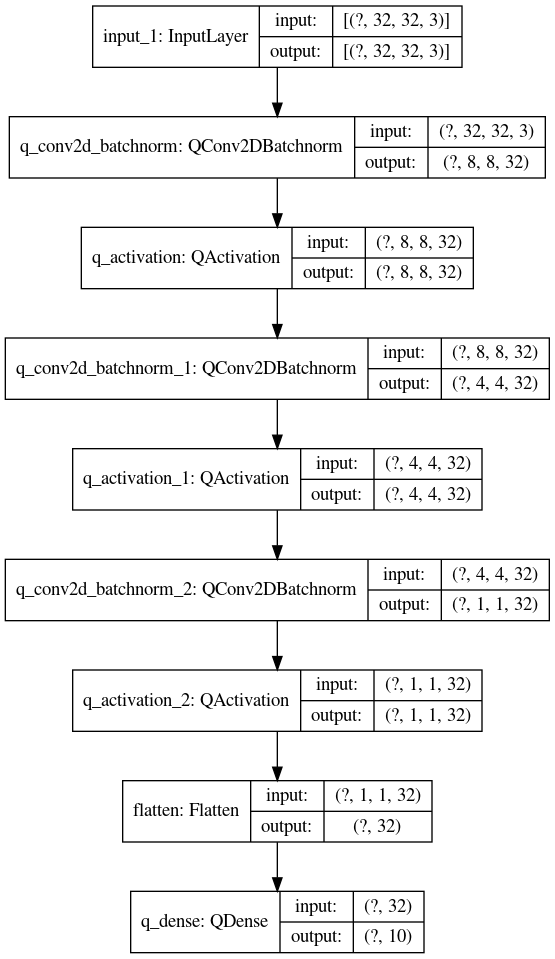

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

**Select a portion of the model to debug**

## Check model sparisty

% of zeros = 0.0


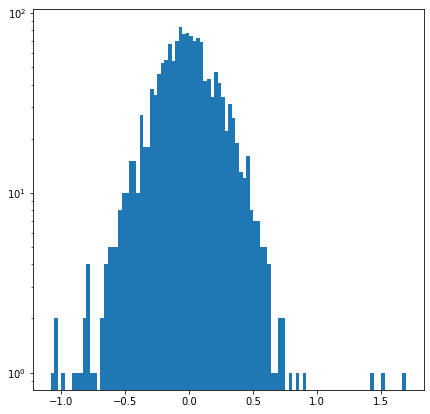

In [8]:
w = model.layers[1].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

Accuracy: 0.7199


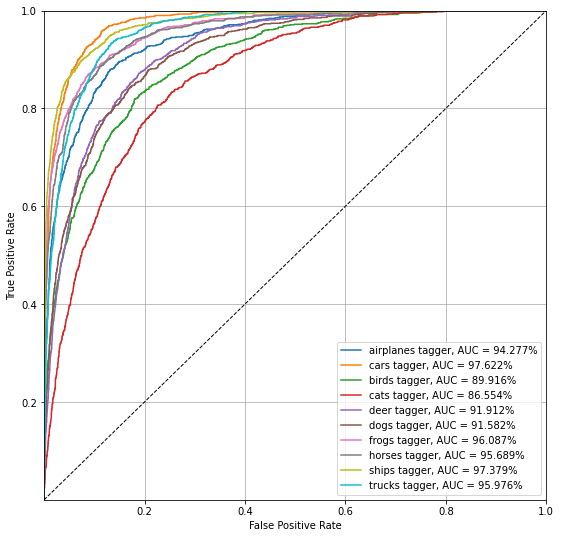

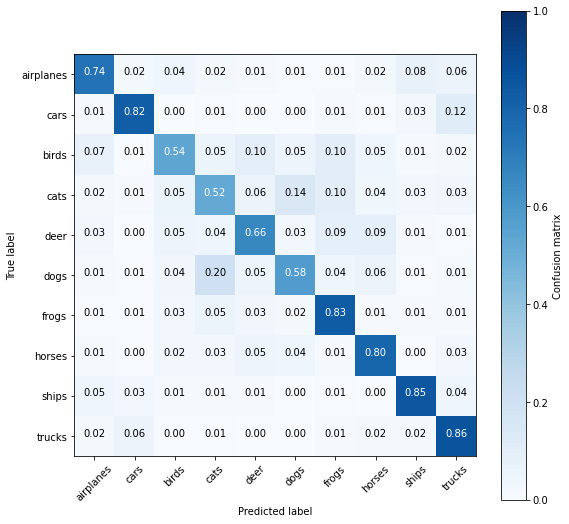

In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import plotting

y_keras = model.predict(X_test)

classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

plt.figure(figsize=(9,9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes)

import plotting # Import local package plotting.py
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_keras, axis=1))
plt.figure(figsize=(9,9))
_ = plotting.plot_confusion_matrix(cm, classes)


## Make an hls4ml configuration

Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [10]:
import yaml

def yaml_load(config):
    with open(config) as stream:
        param = yaml.safe_load(stream)
    return param


#training_config = yaml_load('model/resnet/config_20210424.yml')

# RN03
training_config = yaml_load('model/resnet/rn03/myquant.yml')

# print("-----------------------------------")
#plotting.print_dict(training_config)
# print("-----------------------------------")

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model'] = {}
hls_config['Model']['ReuseFactor'] = training_config['convert']['ReuseFactor']
hls_config['Model']['Strategy'] = training_config['convert']['Strategy']
hls_config['Model']['Precision'] = training_config['convert']['Precision']

## DEBUG DEBUG DEBUG
##
## arrays keys and override_kets have been previously defined
## 
#for name in keys:
#    hls_config['LayerName'][name]['Trace'] = bool(training_config['convert']['Trace'])
#    hls_config['LayerName'][name]['ReuseFactor'] = training_config['convert']['ReuseFactor']
#    hls_config['LayerName'][name]['Precision'] = training_config['convert']['Precision']
#    if 'activation' in name:
#        hls_config['LayerName'][name]['Precision'] = training_config['convert']['PrecisionActivation']
## custom configs
#for name in override_keys:
#    hls_config['LayerName'][name].update(training_config['convert']['Override'][name])
## DEBUG DEBUG DEBUG


# THE ORIGINAL CONFIGURATION
for name in hls_config['LayerName'].keys():
    hls_config['LayerName'][name]['Trace'] = bool(training_config['convert']['Trace'])
    hls_config['LayerName'][name]['ReuseFactor'] = training_config['convert']['ReuseFactor']
    hls_config['LayerName'][name]['Precision'] = training_config['convert']['Precision']
    if 'activation' in name:
        hls_config['LayerName'][name]['Precision'] = training_config['convert']['PrecisionActivation']
# custom configs
for name in training_config['convert']['Override'].keys():
    hls_config['LayerName'][name].update(training_config['convert']['Override'][name])

# Enable tracing for all of the layers
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    
print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm
Layer name: q_activation, layer type: QActivation
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm
Layer name: q_activation_1, layer type: QActivation
Layer name: q_conv2d_batchnorm_2, layer type: QConv2DBatchnorm
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense, layer type: QDense
-----------------------------------
Model
  ReuseFactor:       16384
  Strategy:          Resource
  Precision:         ap_fixed<9,6>
LayerName
  input_1
    Precision:       ap_ufixed<8,1>
    Trace:           True
    ReuseFactor:     16384
  q_conv2d_batchnorm
    Precision
      weight:        ap_fixed<8,3>
      bias:          ap_fixed<8,3>
    ReuseFactor:     16384
    Trace:           True
    accum_t:         ap_fixed<14,6>
  q_activation
    Precision:       ap_ufixed<8,3,AP_RND,AP_SAT>
    ReuseFactor:     16384
    Trace:           T

## Convert and Compile

You can set some target specific configurations:

- Define the `interface`, which for our current setup should always be `m_axi`.
- Define the  width of the AXI bus. For the time being, use `16` that is each clock cycle you transfer a single input or output value (`ap_fixed<16,*>`).
- Define the implementation. For the time being, use `serial`.

In [11]:
interface = 'm_axi' # 's_axilite', 'm_axi', 'io_stream'
axi_width = 8 # 16, 32, 64
implementation = 'serial' # 'serial', 'dataflow'

In [12]:
#output_dir='hls/' + '256x16x8x256_' + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj'
output_dir='hls/' + board_name + '_' + acc_name + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj' 

backend_config = hls4ml.converters.create_backend_config(fpga_part=fpga_part)
backend_config['ProjectName'] = acc_name
backend_config['KerasModel'] = model
backend_config['HLSConfig'] = hls_config
backend_config['OutputDir'] = output_dir
backend_config['Backend'] = 'Pynq'
backend_config['Interface'] = interface
backend_config['IOType'] = 'io_stream'
backend_config['AxiWidth'] = str(axi_width)
backend_config['Implementation'] = implementation
backend_config['ClockPeriod'] = 10

#print("-----------------------------------")
#plotting.print_dict(backend_config)
#print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(backend_config)
# hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                                 hls_config=hls_config,
#                                                                 output_dir=output_dir,
#                                                                 fpga_part=fpga_part,
#                                                                 clock_period=10,
#                                                                 io_type='io_parallel',
#                                                                 project_name='anomaly_detector')

_ = hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 32, 32, 3]]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, current shape: [[None, 32, 32, 3]]
Layer name: q_activation, layer type: Activation, current shape: [[None, 8, 8, 32]]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, current shape: [[None, 8, 8, 32]]
Layer name: q_activation_1, layer type: Activation, current shape: [[None, 4, 4, 32]]
Layer name: q_conv2d_batchnorm_2, layer type: QConv2DBatchnorm, current shape: [[None, 4, 4, 32]]
Layer name: q_activation_2, layer type: Activation, current shape: [[None, 1, 1, 32]]
Layer name: q_dense, layer type: QDense, current shape: [[None, 32]]
Creating HLS model
Writing HLS project
Done


## Profiling

Recompiling resnet with tracing
Writing HLS project
Done
Processing input_1 in Keras model...
Processing q_conv2d_batchnorm in Keras model...
Processing q_activation in Keras model...
Processing q_conv2d_batchnorm_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_conv2d_batchnorm_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing flatten in Keras model...
Processing q_dense in Keras model...
Done taking outputs for Keras model.
Profiling weights
Profiling activations
   input_1
   q_conv2d_batchnorm
   q_activation
   q_conv2d_batchnorm_1
   q_activation_1
   q_conv2d_batchnorm_2
   q_activation_2
   flatten
   q_dense
CPU times: user 2min 58s, sys: 3.98 s, total: 3min 2s
Wall time: 2min 49s


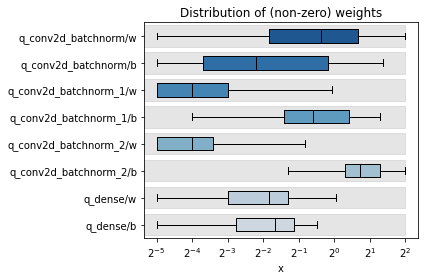

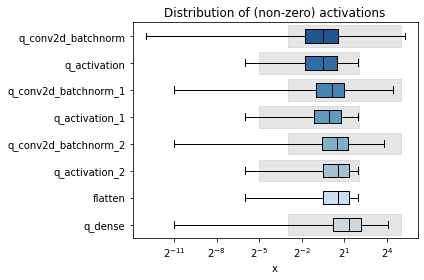

In [13]:
%%time
%matplotlib inline

# Run tracing on the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_test))

# Run tracing on the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

# Run prediction on the test set for the hls model (fixed-point precision)
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

_ = hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test)

Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

## Manual Edits

Edit the following files:
- resnet_test.cpp

```
cd hls/pynqz1_resnet_m_axi_8_serial_prj
cp ../../patches/resnet/resnet_test.cpp ./resnet_test.cpp
cp ../../patches/resnet/resnet_axi.h ./firmware/resnet_axi.h
```

### Run Vivado HLS c-sim for Integrity Test

Edit `build_prj.tcl`

```
array set opt {
  reset      0
  csim       1
  synth      0
  cosim      0
  validation 0
  export     0
  vsynth     0
} 
```

Then 
```
$ vivado_hls -f build_prj.tcl
```

### Generate .so Library

```
$ rm firmware/resnet-*.so 
$ bash build_lib.sh
```

## Prediction and Comparison


-----------------------------------
Keras  Accuracy: 0.7199
hls4ml Accuracy: 0.7215
-----------------------------------


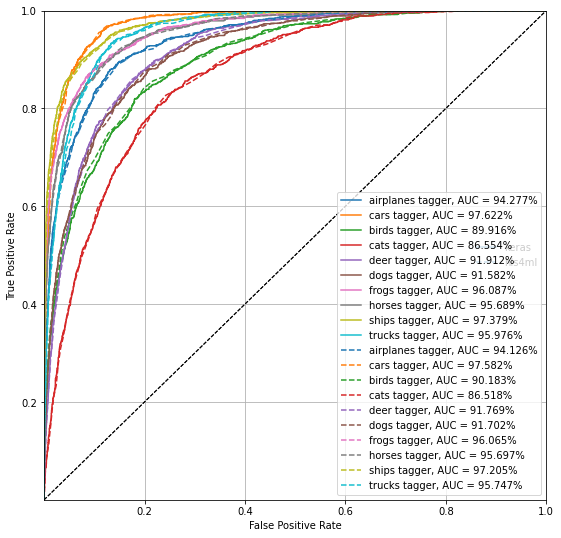

In [14]:
print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='center right', frameon=False)
_ = ax.add_artist(leg)


## Synthesis

In [15]:
hls_model.build(csim=False, synth=True, export=True, vsynth=False)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/artya7100t_resnet_m_axi_8_serial_prj/resnet_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../resnet_test.cpp in debug mode
   Compiling ../../../../firmware/resnet.cpp in debug mode
   Compiling ../../../../firmware/resnet_axi.cpp in debug mode
   Generating csim.exe
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'resnet_axi'
* Date:           Thu May  6 19:38:17 2021

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        resnet_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a100t-csg324-1


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+


## Resource Reference

See the resources availables on different boards.

```
+-----------------+---------+-------+--------+-------+-----+                    
|                 |               Resource                 |
+-----------------+---------+-------+--------+-------+-----+
|      Board      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM|
+-----------------+---------+-------+--------+-------+-----+
|   PYNQ-Z1/Z2    |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|     MiniZed     |      100|     66|   28800|  14400|    0|
+-----------------+---------+-------+--------+-------+-----+
``` 

## Generate .dat Files (Step 3)

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [16]:
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')
# Save the first N images
N=10
for i in range(N):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            for c in range(X_test.shape[3]):
                f.write('{} '.format(X_test[i][j][k][c]))
    f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(N):
    for j in range(y_test.shape[1]):
        f.write('{} '.format(y_test[i][j]))
    f.write('\n')
f.close()

## Run Vivado HLS csim

At this step we generate simulation traces out from the hls4ml-model.

Run the following cell to run Vivado HLS GUI:

In [17]:
!cd $output_dir && vivado_hls -p $acc_name\_prj


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'frodo' (Linux_x86_64 version 4.15.0-142-generic) on Thu May 06 19:39:14 EDT 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial-julesmuhizi/deploy/vivado_flow/hls/artya7100t_resnet_m_axi_8_serial_prj'
INFO: [HLS 200-10] Bringing up Vivado HLS GUI ... 
INFO: [Common 17-206] Exiting vivado_hls at Thu May  6 20:05:49 2021...


**IMPORTANT**  Click the button to `Run C Simulation`.

This will generate simulation traces with fixed-point arythmetic.

## Integrate IP in a Vivado Project and Generate Bitstream (Step 5)

In [18]:
!cd sys/$board_name && make clean sys-gui ACC=$acc_name INTERFACE=$interface

rm -rf *.log *.txt *.jou *.str resnet_project NA
vivado -source tcl/script.tcl -mode gui -tclargs resnet m_axi

****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

start_gui
INFO: [Common 17-206] Exiting Vivado at Thu May  6 20:47:12 2021...


**TODO** Tell the user how to visualize the `Block Diagram` to get a better understanding of the IP integration with both Zynq and MicroBlaze PS.

## Configure Software in Vivado SDK and Run HW/SW on the Board (Step 6)

Create Vivado SDK project.

- `make sdk` to configure an application with register polling
- `make sdk-irq` to configure an application with interrupts (default)

In [21]:
!source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make clean sdk ACC=$acc_name SAMPLE_COUNT=10

rm -rf resnet_standalone
rm -rf resnet_standalone_bsp
rm -rf 
rm -rf _bsp
rm -rf resnet_platform
rm -rf RemoteSystemsTempFiles
rm -rf SDK.log
rm -rf webtalk
rm -rf .sdk
rm -rf .Xil
rm -rf .metadata
rm -rf updatemem*
xsct script.tcl resnet
Starting xsdk. This could take few seconds... done
CRITICAL WARNING: [Board 49-71] The board_part definition was not found for digilentinc.com:arty-a7-100:part0:1.0. The project's board_part property was not set, but the project's part property was set to xc7a100tcsg324-1. Valid board_part values can be retrieved with the 'get_board_parts' Tcl command. Check if board.repoPaths parameter is set and the board_part is installed from the tcl app store.
INFO: [Hsi 55-1698] elapsed time for repository loading 0 seconds
App name
Description
App name
Description
/tools/Xilinx/SDK/2019.1/gnu/microblaze/lin
Application project 'resnet_standalone' created successfully.
make -C ../../utils/dat2header/sim clean
make[1]: Entering directory '/home/giuseppe/teaching/

4f 38 18 4f 37 17 52 3a 19 53 3b 1a 50 38 17 4e 36 14 51 39 17 4f 38 16 4f 37 16 4f 38 14 50 3a 14 50 37 1a 50 37 18 53 3a 14 54 3a 16 55 3b 16 53 3a 14 51 38 13 50 37 13 50 38 15 4e 36 16 4a 35 16 4b 35 16 4a 35 15 4a 35 16 47 32 13 46 31 15 46 30 14 47 30 13 44 2f 12 3f 2d 12 3a 2a 10 4c 38 19 4b 37 14 4f 39 16 53 3a 1c 51 38 18 50 38 15 52 3a 17 51 39 16 51 3a 17 4e 37 13 4d 37 14 4f 37 1b 51 38 1a 55 3b 14 55 3a 14 55 39 10 54 39 f 50 37 10 4d 38 14 4b 39 19 48 37 1a 45 34 1b 46 33 1a 46 32 18 4a 34 19 49 33 17 48 33 16 47 30 13 47 31 11 44 2f f 3e 2d 10 3b 2c 11 4b 37 17 4b 36 10 4f 37 12 53 37 18 50 35 15 51 39 16 52 3a 16 52 3a 16 51 39 15 51 39 15 4f 39 18 4e 36 1c 50 37 19 53 39 13 53 39 12 54 38 11 55 3a 13 4f 39 17 48 37 1b 3c 30 18 37 2d 1a 31 27 19 32 26 17 39 2a 19 3c 2b 18 43 30 1b 47 33 19 46 31 13 47 31 11 45 31 11 41 2f 11 3c 2c 10 4d 35 14 4d 37 10 50 36 f 57 38 16 53 37 15 53 3a 17 54 3c 18 54 3b 18 52 39 16 52 3a 16 53 3d 1c 5f 49 2f 58 41 25 4e 37 14 51 39 17 52 3

    LINK dat2header
make[1]: Leaving directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial-julesmuhizi/deploy/vivado_flow/utils/dat2header/sim'
../../utils/dat2header/sim/dat2header ../../hls/artya7100t_resnet_m_axi_8_serial_prj/tb_data/csim_results.log resnet_standalone/src/dst.h dst 10
INFO: Input file: ../../hls/artya7100t_resnet_m_axi_8_serial_prj/tb_data/csim_results.log
INFO: Output file: resnet_standalone/src/dst.h
ee f0 f2 e f4 7 ff f1 fe fa 2 c f2 ea e3 e3 e4 e3 13 6 8 2 f5 f4 f5 ee ec ef 4 fd d 0 f7 f0 f7 e9 e4 f4 ff 0 de d6 0 5 b f6 d e8 e5 dd eb e1 ee ff fa f8 2 f3 ec e7 f5 e f0 0 ef fb fb fe f1 fc 2 e5 b fb f9 f2 f f0 ee ea f0 dc ff c 7 7 5 2 e6 eb fe 14 f4 f0 f3 e9 f9 f8 ff 15 rm -f resnet_standalone/src/helloworld.c
cd  resnet_standalone/src && ln -s ../../../common/resnet/main_microblaze.c main.c


In [22]:
!xterm -e "sleep 1 && source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make gui && sleep infinity"


You can open a serial console, for example
```
sudo minicom -D /dev/ttyUSB0
```
and see something like

![serial-console](doc/serial_console.png)